In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary
import SimpleITK as sitk

#import utils
import os

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cuda:1"

#utils.set_seeds()

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

print(torch.__version__)
print(device)

2.1.0
cuda


In [2]:
import vnetrec_model
model = vnetrec_model.VNetRec(elu=True, se=True, input_ch=1, split_ch=4).to(device)

In [3]:
# # Create random input sizes
# random_input_image = (2, 1, 320, 320, 16)

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
# summary(model,
#         input_size=random_input_image, # try swapping this for "random_input_image_error"
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [5]:
random_input_image = torch.randn(1, 1, 320, 320, 16).double().to(device)

test_output = model(random_input_image)

test_output.shape

torch.Size([1638400])

In [4]:
#test mha file
#path = '/run/media/davovapo/hdd1-dvp/Projects/picai/data/11474/11474_1001498_t2w.mha'
path = '/run/media/davovapo/hdd1-dvp/Projects/picai/data/11386/11386_1001410_t2w.mha'

In [5]:
image = sitk.ReadImage(path)
image = sitk.GetArrayFromImage(image)


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/run/media/davovapo/hdd1-dvp/Projects/picai/data/11386/11386_1001410_t2w.mha" does not exist.

In [8]:
import os

def get_t2w_list(directory):
  """
  This function retrieves a list of all files within a directory and its subdirectories.

  Args:
      directory (str): Path to the directory to scan.

  Returns:
      list: List containing the paths to all files found.
  """
  file_list = []
  for root, _, files in os.walk(directory):
    for file in files:
      file_path = os.path.join(root, file)
      if "t2w" in file_path:
        file_list.append(file_path)

  file_list = file_list[:30]
  return file_list

# Get the directory path
directory = "../picai/train/"

# Get all files in the directory and subdirectories
all_files = get_t2w_list(directory)

print(len(all_files))

30


In [13]:
## Dataset Class
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import SimpleITK as sitk
from skimage.transform import resize
from scipy.stats import zscore
import bq_transforms

class Rec_Dataset(Dataset):
    def __init__(self, data_folder, transform=None, normalize=True, num_frames=16):
        self.data_folder = data_folder
        self.image_folder = os.path.join(data_folder, 'image')
        self.transform = transform
        self.normalize = normalize

        self.file_list = sorted(set(get_t2w_list(data_folder)))

        #we need to make a dictionary with index and a list of the total indices
        self.num_frames = num_frames
        self.index_mapping, self.frame_mapping, self.total_length, self.path_mapping = self.build_mapping()

    def extract_overlapping_slices(self, data, slice_size, check_empty=False):
        h, w, num_frames = data.shape
        slices = []
        for start_frame in range(0, num_frames - slice_size + 1):
            slice_data = data[:, :, start_frame:start_frame + slice_size]
            #check here if slice_data for the mask is empty
            if not check_empty:
                slices.append(slice_data)
            elif np.any(slice_data == 1):
                slices.append(slice_data)
        return slices

    def build_mapping(self):
        index_mapping = {}
        frame_mapping = {}
        path_mapping = {}
        total_index = 0

        for filepath in self.file_list:
            if filepath.endswith(".mha"):
                #index = filename.split(".")[0]  # Extract the index from the filename
                index = filepath.split('/')[-2]
                image_path = filepath

                # Load the 3D numpy array
                #image_data = np.load(image_path).astype(np.float32)
                image_data = sitk.GetArrayFromImage(sitk.ReadImage(image_path)).astype(np.float32)
                image_data = np.transpose(image_data, (1, 2, 0))
                
                # Check for bad images that cannot be normalized and skip
                check_std = np.std(np.expand_dims(image_data, axis=2), axis=(0,1,2), keepdims=True)
                if (np.any(check_std == 0)):
                    continue
                
                # Extract overlapping 3D arrays of size (h, w, 16)
                image_slices = self.extract_overlapping_slices(image_data, slice_size=self.num_frames)

                # Update the mapping with the original index and total index
                for i in range(len(image_slices)):
                    index_mapping[total_index] = int(index)
                    frame_mapping[total_index] = int(i)
                    path_mapping[total_index] = image_path
                    total_index += 1
        
        return index_mapping, frame_mapping, total_index, path_mapping

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):

        image_index = self.index_mapping.get(idx)
        frame_index = self.frame_mapping.get(idx)
        image_path = self.path_mapping.get(idx)
        
        image_data = sitk.GetArrayFromImage(sitk.ReadImage(image_path)).astype(np.float32)
        image_data = np.transpose(image_data, (1, 2, 0))
        
        # Extract the specific subarray based on the frame index
        image = image_data[:, :, frame_index:frame_index + self.num_frames]

        # Add mono channel
        image = np.expand_dims(image, axis=2)
        
        ## anomalies check for the inputs
        # if (np.isnan(image).any()):
        #     print("NaN found in NumPy arrays after normalization!")
        # if (np.isinf(image).any()):
        #     print("Inf found in NumPy arrays after normalization!")
        # if (np.all(image == 0)):
        #     print("All zeros found in NumPy arrays after normalization!")

        #Apply initial transform
        if self.transform:  
            transformed_frames = []
            
            state = torch.get_rng_state()
            
            for frame in range(image.shape[-1]):
                #print(image[:, :, :, frame].shape)
                torch.set_rng_state(state)
                transformed_frame = self.transform(image[:, :, :, frame])
                transformed_frames.append(transformed_frame)

            image = torch.stack(transformed_frames, dim=-1)

        bq_state = np.random.get_state()
        transformed_frames = []

        # TODO: inhomogenities for all volume not per frame
        # bool_inhomogenity = False
        # if np.random.rand() < 0.33:
        #     bool_inhomogenity = True
            
        for frame in range(image.shape[-1]):

            num_alterations = np.random.randint(1, high=4)
            
            choice_vec = np.array([False] * 7)
            true_vec = np.random.choice(7, num_alterations, replace=False)
            choice_vec[true_vec] = True

            transformed_frame = image[:, :, :, frame].squeeze().numpy()

            if choice_vec[0]:
                transformed_frame = bq_transforms.simulate_blurring_ghosting(transformed_frame)

            if choice_vec[1]:
                transformed_frame = bq_transforms.add_gaussian_noise(transformed_frame)
                
            if choice_vec[2]:
                transformed_frame = bq_transforms.simulate_axis_ghosting(transformed_frame)

            if choice_vec[3]:
                transformed_frame = bq_transforms.simulate_partial_volume_effect(transformed_frame)

            if choice_vec[4]:
                transformed_frame = bq_transforms.simulate_gradient_nonlinearity(transformed_frame)

            if choice_vec[5]:
                transformed_frame = bq_transforms.simulate_motion_artifacts(transformed_frame)
                
            if choice_vec[6]:
                transformed_frame = bq_transforms.simulate_inhomogeneities(transformed_frame)

            # if choice_vec[7]:
            #     transformed_frame = bq_transforms.simulate_aliasing(transformed_frame)

            transformed_frames.append(transformed_frame)
        
        bq_image = np.stack(transformed_frames, axis=-1)
        bq_image = torch.from_numpy(bq_image).unsqueeze(dim=0)
        
        #print(bq_image.shape)
        
        # if torch.isnan(image).any():
        #     print("NaN values found in PyTorch tensors!")
        #     print(image_filename)
        # if torch.isinf(image).any():
        #     print("Inf values found in PyTorch tensors!")
        #     print(image_filename)
        
        # torch wants dimensions (batch_size, c, h, w, frames)
        # transpose here if needed

        # Z-score normalization
        if self.normalize:
            mean = np.mean(image.numpy(), axis=(0,1,2), keepdims=True)
            std = np.std(image.numpy(), axis=(0,1,2), keepdims=True)
            image = (image.numpy() - mean) / (std)
            
            mean = np.mean(bq_image.numpy(), axis=(0,1,2), keepdims=True)
            std = np.std(bq_image.numpy(), axis=(0,1,2), keepdims=True)
            bq_image = (bq_image.numpy() - mean) / (std)

            image = torch.from_numpy(image)
            bq_image = torch.from_numpy(bq_image)
        
        return bq_image.double(), image.double()


In [14]:
aug_transform = transforms.Compose([
    transforms.ToPILImage(mode='F'),  # F for 32-bit floating point pixels
    # transforms.CenterCrop((360, 360)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(320, 320), scale=(0.3,1), ratio=(1, 1)),
    transforms.ToTensor()
])

train_data = Rec_Dataset(directory, transform=aug_transform, normalize=True, num_frames=16)

In [15]:
len(train_data)

222

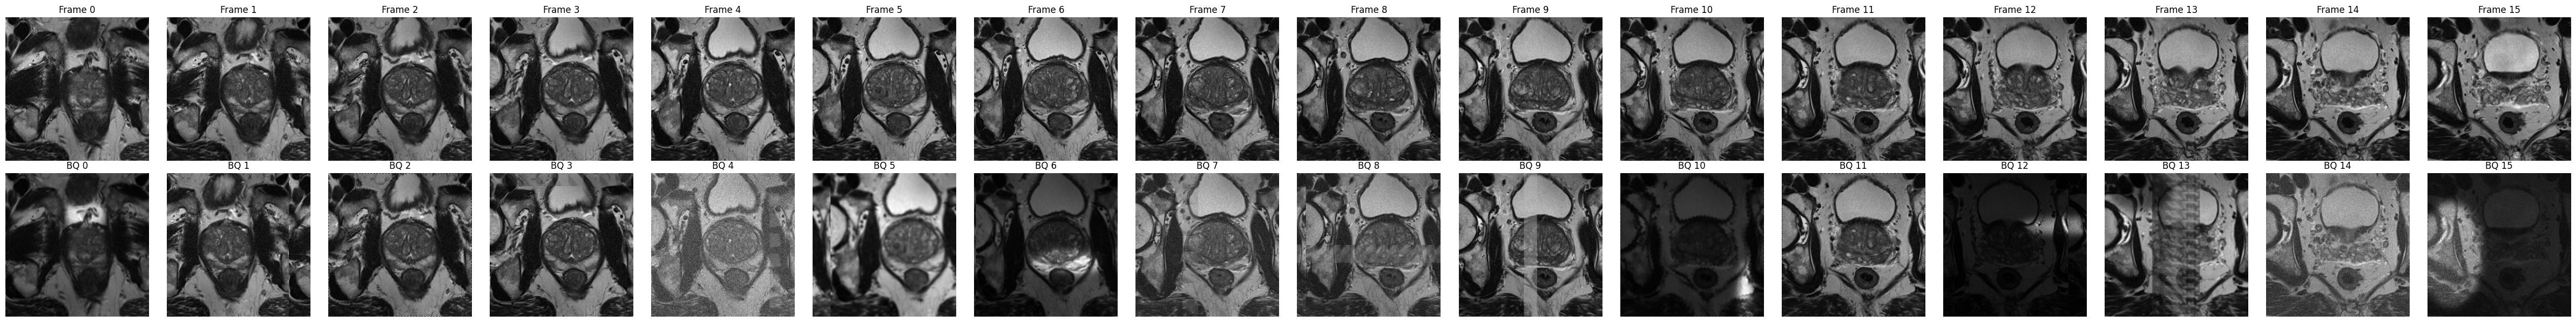

In [16]:
import utils

idx = 123
image, bq_image = train_data[idx]
utils.plot_all_frames(bq_image, image)